In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import ariel_simple
import tqdm

local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 459 ms, sys: 108 ms, total: 567 ms
Wall time: 1.8 s


(1100, 1)

In [3]:
def robust_linear_fit_rms(X, Y, drop_frac=0.05, do_print=False):
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Fit Y = aX + b using least squares
    A = np.vstack([X, np.ones_like(X)]).T
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Predicted Y and residuals
    Y_pred = a * X + b
    residuals = Y - Y_pred
    abs_resid = np.abs(residuals)

    # Remove worst 5% (highest absolute residuals)
    if drop_frac>0:
        n = len(residuals)
        keep = int(n * (1 - drop_frac))
        indices = np.argpartition(abs_resid, keep)[:keep]
    #print(keep, len(residuals))
    else:
        indices = np.arange(len(residuals))

    # Compute RMS of the remaining residuals
    rms = np.sqrt(np.mean(residuals[indices] ** 2))
    if do_print:
        print(a,b)
    return rms,residuals

In [4]:
df = 0.05
kgs.sanity_checks_without_errors = True
for jj in range(13):
    model = ariel_simple.SimpleModel()
    model.run_in_parallel = (jj<6)
    model.order_list = [0,1,2,3]
    match jj:
        case 0:
            name = 'Third order'
        case 1:
            name = 'Supersample'
            model.supersample_factor = 5
        case 2:
            name = 'Fit eccentricity'
            model.fit_ecc = True
        case 3:
            name = 'Correction factor'
            model.use_correction_factor = True
        case 4:
            name = '2nd order'
            model.order_list = [0,1,2]
        case 5:
            name = '4th order'
            model.order_list = [0,1,2,3,4]
        case 6:
            name = 'Keep background rows'
            model.loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
        case 7:
            name = 'Don''t mask hot'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.mask_hot = False
            model.run_in_parallel = False
        case 8:
            name = 'No linear correction'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.linear_correction = False
        case 9:
            name = 'Dark current sign'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.dark_current_sign *= -1
        case 10:
            name = 'ADC sign'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.adc_offset_sign *= -1
        case 11:
            name = 'No flat field'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.flat_field = False
        case 12:
            name = 'Time binning x2'
            for ii in range(2):
                model.loaders[ii].apply_time_binning.time_binning*=2                
    model.train(train_data)
    data = train_data
    inferred_data = model.infer(data)
    print(name)
    solution = kgs.make_submission_dataframe(data, include_sigma=False)
    submission = kgs.make_submission_dataframe(inferred_data, False)
    print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df)[0], 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0)[0])
    print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df)[0],
         1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0)[0])
    kgs.sanity_checks['simple_residual_diff_FGS'] = kgs.SanityCheckValue('simple_residual_diff_FGS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_FGS'].seen_all = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
    kgs.sanity_checks['simple_residual_diff_AIRS'] = kgs.SanityCheckValue('simple_residual_diff_AIRS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
    kgs.dill_save(kgs.temp_dir + '/compare_simple'+str(jj)+'.pickle', (data,inferred_data,kgs.sanity_checks,name))

Processing in parallel: 100%|███████████████████████████████████████████████████████| 1100/1100 [04:48<00:00,  3.82it/s]


local
local
local
local
local
local
local
Third order
136.14812821204038 237.56301682844597
74.49435476278323 197.99284908426384


Processing in parallel: 100%|███████████████████████████████████████████████████████| 1100/1100 [10:12<00:00,  1.80it/s]


local
local
local
local
local
local
local
Supersample
137.11347988444032 234.9010877944375
74.90957642600546 190.00791903895842


Processing in parallel: 100%|███████████████████████████████████████████████████████| 1100/1100 [05:40<00:00,  3.23it/s]


local
local
local
local
local
local
Fit eccentricity
143.90300749107428 1167.1198729106427
78.86222916958694 1254.213131357098


Processing in parallel: 100%|███████████████████████████████████████████████████████| 1100/1100 [05:11<00:00,  3.53it/s]


local
local
local
local
local
local
local
Correction factor
172.60994762161195 261.93282874365724
81.85655096539318 204.30903888900198


Processing in parallel: 100%|███████████████████████████████████████████████████████| 1100/1100 [04:36<00:00,  3.99it/s]


local
local
local
local
local
local
2nd order
155.5982121858694 272.37372798514554
120.04545749665647 249.23017405449335


Processing in parallel: 100%|███████████████████████████████████████████████████████| 1100/1100 [05:16<00:00,  3.48it/s]


local
local
local
local
local
local
local
4th order
153.60367000646355 264.9329797359857
69.57088140922706 196.40767404769832


Inferring: 100%|████████████████████████████████████████████████████████████████████| 1100/1100 [48:06<00:00,  2.62s/it]


Keep background rows
137.04279531464516 232.1812943077796
80.38198412678359 203.21752156497118


Inferring:   0%|                                                                               | 0/1100 [00:00<?, ?it/s]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   0%|                                                                       | 1/1100 [00:02<43:59,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   0%|▏                                                                      | 2/1100 [00:05<47:12,  2.58s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   0%|▏                                                                      | 3/1100 [00:07<46:23,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   0%|▎                                                                      | 4/1100 [00:09<45:31,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   0%|▎                                                                      | 5/1100 [00:12<44:55,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▍                                                                      | 6/1100 [00:14<44:04,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▍                                                                      | 7/1100 [00:17<44:16,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▌                                                                      | 8/1100 [00:19<44:30,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▌                                                                      | 9/1100 [00:21<43:59,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▋                                                                     | 10/1100 [00:24<43:51,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▋                                                                     | 11/1100 [00:26<44:16,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▊                                                                     | 12/1100 [00:29<43:56,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▊                                                                     | 13/1100 [00:30<42:10,  2.33s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▉                                                                     | 14/1100 [00:33<42:25,  2.34s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|▉                                                                     | 15/1100 [00:35<42:34,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   1%|█                                                                     | 16/1100 [00:38<42:38,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█                                                                     | 17/1100 [00:40<43:06,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▏                                                                    | 18/1100 [00:43<43:26,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▏                                                                    | 19/1100 [00:45<43:15,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▎                                                                    | 20/1100 [00:47<43:09,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▎                                                                    | 21/1100 [00:50<43:10,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▍                                                                    | 22/1100 [00:52<42:53,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▍                                                                    | 23/1100 [00:55<42:53,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▌                                                                    | 24/1100 [00:57<42:52,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▌                                                                    | 25/1100 [00:59<42:52,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▋                                                                    | 26/1100 [01:01<41:55,  2.34s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   2%|█▋                                                                    | 27/1100 [01:03<42:01,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|█▊                                                                    | 28/1100 [01:06<42:06,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|█▊                                                                    | 29/1100 [01:09<42:19,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|█▉                                                                    | 30/1100 [01:11<42:55,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|█▉                                                                    | 31/1100 [01:14<43:22,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|██                                                                    | 32/1100 [01:17<43:38,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|██                                                                    | 33/1100 [01:19<43:32,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|██▏                                                                   | 34/1100 [01:22<43:43,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|██▏                                                                   | 35/1100 [01:25<43:59,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|██▎                                                                   | 36/1100 [01:27<44:05,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|██▎                                                                   | 37/1100 [01:30<44:13,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   3%|██▍                                                                   | 38/1100 [01:32<43:25,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▍                                                                   | 39/1100 [01:34<43:18,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▌                                                                   | 40/1100 [01:37<43:11,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▌                                                                   | 41/1100 [01:39<43:06,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▋                                                                   | 42/1100 [01:41<43:02,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▋                                                                   | 43/1100 [01:44<43:35,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▊                                                                   | 44/1100 [01:47<43:35,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▊                                                                   | 45/1100 [01:49<43:24,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▉                                                                   | 46/1100 [01:52<43:23,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|██▉                                                                   | 47/1100 [01:55<43:45,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|███                                                                   | 48/1100 [01:57<43:51,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   4%|███                                                                   | 49/1100 [02:00<43:47,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▏                                                                  | 50/1100 [02:02<43:46,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▏                                                                  | 51/1100 [02:04<42:53,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▎                                                                  | 52/1100 [02:06<42:53,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▎                                                                  | 53/1100 [02:09<42:37,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▍                                                                  | 54/1100 [02:11<42:48,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▌                                                                  | 55/1100 [02:14<42:40,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▌                                                                  | 56/1100 [02:16<42:24,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▋                                                                  | 57/1100 [02:18<42:26,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▋                                                                  | 58/1100 [02:21<42:22,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▊                                                                  | 59/1100 [02:24<42:35,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   5%|███▊                                                                  | 60/1100 [02:26<42:49,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|███▉                                                                  | 61/1100 [02:29<42:50,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|███▉                                                                  | 62/1100 [02:31<42:54,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████                                                                  | 63/1100 [02:34<42:42,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████                                                                  | 64/1100 [02:35<41:57,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▏                                                                 | 65/1100 [02:38<41:38,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▏                                                                 | 66/1100 [02:40<41:29,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▎                                                                 | 67/1100 [02:42<41:22,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▎                                                                 | 68/1100 [02:45<41:29,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▍                                                                 | 69/1100 [02:48<42:17,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▍                                                                 | 70/1100 [02:51<42:24,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▌                                                                 | 71/1100 [02:53<42:16,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▌                                                                 | 72/1100 [02:56<42:23,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▋                                                                 | 73/1100 [02:58<42:21,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▋                                                                 | 74/1100 [03:01<42:11,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▊                                                                 | 75/1100 [03:03<42:03,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▊                                                                 | 76/1100 [03:05<42:05,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▉                                                                 | 77/1100 [03:07<41:29,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▉                                                                 | 78/1100 [03:10<41:15,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|█████                                                                 | 79/1100 [03:12<41:14,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|█████                                                                 | 80/1100 [03:14<41:10,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|█████▏                                                                | 81/1100 [03:17<41:10,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|█████▏                                                                | 82/1100 [03:19<41:08,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▎                                                                | 83/1100 [03:22<41:08,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▎                                                                | 84/1100 [03:24<40:57,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▍                                                                | 85/1100 [03:26<40:58,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▍                                                                | 86/1100 [03:29<41:04,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▌                                                                | 87/1100 [03:32<41:08,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▌                                                                | 88/1100 [03:34<40:51,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▋                                                                | 89/1100 [03:36<40:49,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▋                                                                | 90/1100 [03:38<40:19,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▊                                                                | 91/1100 [03:41<40:23,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▊                                                                | 92/1100 [03:43<40:19,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▉                                                                | 93/1100 [03:45<40:07,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|█████▉                                                                | 94/1100 [03:48<40:09,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████                                                                | 95/1100 [03:50<40:13,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████                                                                | 96/1100 [03:53<40:34,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▏                                                               | 97/1100 [03:56<40:35,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▏                                                               | 98/1100 [03:58<40:25,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▎                                                               | 99/1100 [04:00<40:26,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▎                                                              | 100/1100 [04:03<40:25,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▎                                                              | 101/1100 [04:05<40:32,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▍                                                              | 102/1100 [04:08<40:34,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▍                                                              | 103/1100 [04:09<39:48,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▌                                                              | 104/1100 [04:12<39:55,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▌                                                              | 105/1100 [04:15<39:56,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▋                                                              | 106/1100 [04:17<39:56,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▋                                                              | 107/1100 [04:19<39:52,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▊                                                              | 108/1100 [04:22<39:53,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▊                                                              | 109/1100 [04:24<39:39,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▉                                                              | 110/1100 [04:26<39:38,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▉                                                              | 111/1100 [04:29<39:32,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|███████                                                              | 112/1100 [04:31<39:33,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|███████                                                              | 113/1100 [04:34<39:33,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|███████▏                                                             | 114/1100 [04:36<39:33,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|███████▏                                                             | 115/1100 [04:39<39:34,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▎                                                             | 116/1100 [04:41<39:37,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▎                                                             | 117/1100 [04:43<38:50,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▍                                                             | 118/1100 [04:45<38:50,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▍                                                             | 119/1100 [04:47<38:49,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▌                                                             | 120/1100 [04:50<38:51,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▌                                                             | 121/1100 [04:53<39:02,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▋                                                             | 122/1100 [04:55<39:01,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▋                                                             | 123/1100 [04:57<38:54,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▊                                                             | 124/1100 [05:00<39:00,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▊                                                             | 125/1100 [05:02<39:00,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▉                                                             | 126/1100 [05:05<38:55,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|███████▉                                                             | 127/1100 [05:07<39:06,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████                                                             | 128/1100 [05:10<39:15,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████                                                             | 129/1100 [05:13<39:28,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▏                                                            | 130/1100 [05:14<38:53,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▏                                                            | 131/1100 [05:17<38:53,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▎                                                            | 132/1100 [05:20<38:58,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▎                                                            | 133/1100 [05:22<39:15,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▍                                                            | 134/1100 [05:25<39:11,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▍                                                            | 135/1100 [05:27<39:18,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▌                                                            | 136/1100 [05:30<39:28,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▌                                                            | 137/1100 [05:33<39:27,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|████████▋                                                            | 138/1100 [05:35<39:30,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|████████▋                                                            | 139/1100 [05:39<40:16,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|████████▊                                                            | 140/1100 [05:41<40:20,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|████████▊                                                            | 141/1100 [05:44<40:27,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|████████▉                                                            | 142/1100 [05:46<39:41,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|████████▉                                                            | 143/1100 [05:48<39:32,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|█████████                                                            | 144/1100 [05:50<39:17,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|█████████                                                            | 145/1100 [05:53<39:09,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|█████████▏                                                           | 146/1100 [05:55<39:05,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|█████████▏                                                           | 147/1100 [05:57<38:56,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|█████████▎                                                           | 148/1100 [06:00<39:10,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▎                                                           | 149/1100 [06:03<39:07,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▍                                                           | 150/1100 [06:05<39:06,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▍                                                           | 151/1100 [06:08<39:09,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▌                                                           | 152/1100 [06:10<39:12,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▌                                                           | 153/1100 [06:13<39:06,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▋                                                           | 154/1100 [06:15<39:07,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▋                                                           | 155/1100 [06:17<38:22,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▊                                                           | 156/1100 [06:19<38:21,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▊                                                           | 157/1100 [06:21<38:11,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▉                                                           | 158/1100 [06:24<38:13,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▉                                                           | 159/1100 [06:26<37:59,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████                                                           | 160/1100 [06:29<37:56,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████                                                           | 161/1100 [06:31<37:49,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▏                                                          | 162/1100 [06:34<37:56,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▏                                                          | 163/1100 [06:36<37:50,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▎                                                          | 164/1100 [06:38<37:41,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▎                                                          | 165/1100 [06:41<37:47,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▍                                                          | 166/1100 [06:43<37:46,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▍                                                          | 167/1100 [06:46<37:53,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▌                                                          | 168/1100 [06:48<37:18,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▌                                                          | 169/1100 [06:51<37:55,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▋                                                          | 170/1100 [06:54<38:07,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|██████████▋                                                          | 171/1100 [06:56<38:01,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|██████████▊                                                          | 172/1100 [06:58<37:54,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|██████████▊                                                          | 173/1100 [07:01<37:44,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|██████████▉                                                          | 174/1100 [07:03<37:35,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|██████████▉                                                          | 175/1100 [07:05<37:33,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████                                                          | 176/1100 [07:08<37:43,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████                                                          | 177/1100 [07:11<37:48,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████▏                                                         | 178/1100 [07:13<37:54,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████▏                                                         | 179/1100 [07:16<38:01,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████▎                                                         | 180/1100 [07:19<38:01,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████▎                                                         | 181/1100 [07:20<37:24,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▍                                                         | 182/1100 [07:23<37:31,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▍                                                         | 183/1100 [07:26<37:36,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▌                                                         | 184/1100 [07:28<37:27,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▌                                                         | 185/1100 [07:30<37:28,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▋                                                         | 186/1100 [07:33<37:32,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▋                                                         | 187/1100 [07:36<37:35,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▊                                                         | 188/1100 [07:38<37:33,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▊                                                         | 189/1100 [07:40<37:28,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▉                                                         | 190/1100 [07:43<37:25,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|███████████▉                                                         | 191/1100 [07:45<37:15,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|████████████                                                         | 192/1100 [07:48<37:10,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████                                                         | 193/1100 [07:50<37:06,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▏                                                        | 194/1100 [07:52<36:37,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▏                                                        | 195/1100 [07:54<36:40,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▎                                                        | 196/1100 [07:57<36:40,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▎                                                        | 197/1100 [07:59<36:34,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▍                                                        | 198/1100 [08:02<36:30,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▍                                                        | 199/1100 [08:04<36:36,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▌                                                        | 200/1100 [08:07<36:32,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▌                                                        | 201/1100 [08:09<36:25,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▋                                                        | 202/1100 [08:11<36:19,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▋                                                        | 203/1100 [08:14<36:20,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|████████████▊                                                        | 204/1100 [08:16<36:14,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|████████████▊                                                        | 205/1100 [08:19<36:24,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|████████████▉                                                        | 206/1100 [08:22<36:30,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|████████████▉                                                        | 207/1100 [08:23<35:58,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████                                                        | 208/1100 [08:26<36:06,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████                                                        | 209/1100 [08:29<36:15,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████▏                                                       | 210/1100 [08:31<36:18,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████▏                                                       | 211/1100 [08:34<36:32,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████▎                                                       | 212/1100 [08:37<36:46,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████▎                                                       | 213/1100 [08:39<36:43,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████▍                                                       | 214/1100 [08:42<36:34,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▍                                                       | 215/1100 [08:44<36:23,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▌                                                       | 216/1100 [08:47<36:28,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▌                                                       | 217/1100 [08:49<36:36,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▋                                                       | 218/1100 [08:52<36:26,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▋                                                       | 219/1100 [08:53<35:41,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▊                                                       | 220/1100 [08:55<35:30,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▊                                                       | 221/1100 [08:58<35:33,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▉                                                       | 222/1100 [09:00<35:29,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▉                                                       | 223/1100 [09:03<35:25,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|██████████████                                                       | 224/1100 [09:05<35:24,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|██████████████                                                       | 225/1100 [09:08<35:23,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▏                                                      | 226/1100 [09:10<35:18,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▏                                                      | 227/1100 [09:12<35:15,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▎                                                      | 228/1100 [09:15<35:19,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▎                                                      | 229/1100 [09:17<35:09,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▍                                                      | 230/1100 [09:20<34:59,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▍                                                      | 231/1100 [09:22<35:02,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▌                                                      | 232/1100 [09:25<35:07,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▌                                                      | 233/1100 [09:26<34:29,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▋                                                      | 234/1100 [09:29<34:32,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▋                                                      | 235/1100 [09:31<34:43,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▊                                                      | 236/1100 [09:34<34:41,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|██████████████▊                                                      | 237/1100 [09:36<34:40,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|██████████████▉                                                      | 238/1100 [09:39<34:49,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|██████████████▉                                                      | 239/1100 [09:42<34:56,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████                                                      | 240/1100 [09:44<35:01,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████                                                      | 241/1100 [09:47<34:57,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▏                                                     | 242/1100 [09:49<34:54,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▏                                                     | 243/1100 [09:52<35:09,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▎                                                     | 244/1100 [09:54<35:10,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▎                                                     | 245/1100 [09:56<34:37,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▍                                                     | 246/1100 [09:59<34:35,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▍                                                     | 247/1100 [10:01<34:22,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▌                                                     | 248/1100 [10:03<34:21,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▌                                                     | 249/1100 [10:06<34:21,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▋                                                     | 250/1100 [10:08<34:26,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▋                                                     | 251/1100 [10:11<34:26,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▊                                                     | 252/1100 [10:13<34:23,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▊                                                     | 253/1100 [10:16<34:17,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▉                                                     | 254/1100 [10:18<34:21,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|███████████████▉                                                     | 255/1100 [10:20<34:08,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|████████████████                                                     | 256/1100 [10:23<33:57,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|████████████████                                                     | 257/1100 [10:25<33:45,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|████████████████▏                                                    | 258/1100 [10:27<33:42,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▏                                                    | 259/1100 [10:29<33:02,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▎                                                    | 260/1100 [10:31<32:55,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▎                                                    | 261/1100 [10:33<32:51,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▍                                                    | 262/1100 [10:36<32:47,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▍                                                    | 263/1100 [10:38<32:42,  2.34s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▌                                                    | 264/1100 [10:40<32:40,  2.34s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▌                                                    | 265/1100 [10:43<32:47,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▋                                                    | 266/1100 [10:45<32:55,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▋                                                    | 267/1100 [10:48<33:06,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▊                                                    | 268/1100 [10:51<33:13,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▊                                                    | 269/1100 [10:53<33:07,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|████████████████▉                                                    | 270/1100 [10:55<33:07,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|████████████████▉                                                    | 271/1100 [10:58<33:00,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████                                                    | 272/1100 [10:59<32:25,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████                                                    | 273/1100 [11:02<32:36,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▏                                                   | 274/1100 [11:05<32:42,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▎                                                   | 275/1100 [11:07<32:44,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▎                                                   | 276/1100 [11:09<32:39,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▍                                                   | 277/1100 [11:12<32:38,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▍                                                   | 278/1100 [11:14<32:38,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▌                                                   | 279/1100 [11:17<32:37,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▌                                                   | 280/1100 [11:19<32:32,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|█████████████████▋                                                   | 281/1100 [11:22<32:37,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|█████████████████▋                                                   | 282/1100 [11:24<32:36,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|█████████████████▊                                                   | 283/1100 [11:27<32:46,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|█████████████████▊                                                   | 284/1100 [11:29<32:47,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|█████████████████▉                                                   | 285/1100 [11:31<32:09,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|█████████████████▉                                                   | 286/1100 [11:33<32:04,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████                                                   | 287/1100 [11:35<31:55,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████                                                   | 288/1100 [11:38<31:56,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████▏                                                  | 289/1100 [11:40<31:58,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████▏                                                  | 290/1100 [11:44<32:46,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████▎                                                  | 291/1100 [11:46<32:56,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▎                                                  | 292/1100 [11:49<32:48,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▍                                                  | 293/1100 [11:51<32:45,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▍                                                  | 294/1100 [11:54<32:45,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▌                                                  | 295/1100 [11:56<32:39,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▌                                                  | 296/1100 [11:58<32:37,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▋                                                  | 297/1100 [12:01<32:38,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▋                                                  | 298/1100 [12:03<32:19,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▊                                                  | 299/1100 [12:05<32:11,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▊                                                  | 300/1100 [12:08<32:05,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▉                                                  | 301/1100 [12:10<32:14,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|██████████████████▉                                                  | 302/1100 [12:13<32:19,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████                                                  | 303/1100 [12:15<32:17,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████                                                  | 304/1100 [12:18<32:07,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▏                                                 | 305/1100 [12:20<32:06,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▏                                                 | 306/1100 [12:23<32:06,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▎                                                 | 307/1100 [12:25<32:09,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▎                                                 | 308/1100 [12:28<32:07,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▍                                                 | 309/1100 [12:30<32:03,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▍                                                 | 310/1100 [12:33<32:11,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▌                                                 | 311/1100 [12:34<31:40,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▌                                                 | 312/1100 [12:37<31:29,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▋                                                 | 313/1100 [12:39<31:31,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|███████████████████▋                                                 | 314/1100 [12:42<31:39,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|███████████████████▊                                                 | 315/1100 [12:44<31:48,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|███████████████████▊                                                 | 316/1100 [12:47<32:00,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|███████████████████▉                                                 | 317/1100 [12:49<31:47,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|███████████████████▉                                                 | 318/1100 [12:52<31:44,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|████████████████████                                                 | 319/1100 [12:54<31:46,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|████████████████████                                                 | 320/1100 [12:57<31:46,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|████████████████████▏                                                | 321/1100 [12:59<31:38,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|████████████████████▏                                                | 322/1100 [13:01<31:25,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|████████████████████▎                                                | 323/1100 [13:04<31:32,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|████████████████████▎                                                | 324/1100 [13:06<31:09,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▍                                                | 325/1100 [13:09<31:17,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▍                                                | 326/1100 [13:11<31:18,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▌                                                | 327/1100 [13:14<31:25,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▌                                                | 328/1100 [13:16<31:23,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▋                                                | 329/1100 [13:19<31:33,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▋                                                | 330/1100 [13:22<31:43,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▊                                                | 331/1100 [13:25<32:08,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▊                                                | 332/1100 [13:28<32:35,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▉                                                | 333/1100 [13:31<32:33,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▉                                                | 334/1100 [13:33<32:32,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|█████████████████████                                                | 335/1100 [13:36<32:26,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████                                                | 336/1100 [13:38<31:54,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▏                                               | 337/1100 [13:40<31:44,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▏                                               | 338/1100 [13:43<31:48,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▎                                               | 339/1100 [13:45<31:46,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▎                                               | 340/1100 [13:48<31:41,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▍                                               | 341/1100 [13:50<31:34,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▍                                               | 342/1100 [13:52<31:24,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▌                                               | 343/1100 [13:55<31:20,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▌                                               | 344/1100 [13:57<31:17,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▋                                               | 345/1100 [14:00<31:26,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|█████████████████████▋                                               | 346/1100 [14:02<31:13,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|█████████████████████▊                                               | 347/1100 [14:05<31:08,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|█████████████████████▊                                               | 348/1100 [14:07<31:09,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|█████████████████████▉                                               | 349/1100 [14:09<30:41,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|█████████████████████▉                                               | 350/1100 [14:12<30:50,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████                                               | 351/1100 [14:15<31:06,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████                                               | 352/1100 [14:17<31:09,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████▏                                              | 353/1100 [14:20<31:29,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████▏                                              | 354/1100 [14:23<31:27,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████▎                                              | 355/1100 [14:26<31:34,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████▎                                              | 356/1100 [14:28<31:30,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████▍                                              | 357/1100 [14:30<31:16,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▍                                              | 358/1100 [14:33<31:07,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▌                                              | 359/1100 [14:35<30:59,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▌                                              | 360/1100 [14:37<30:47,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▋                                              | 361/1100 [14:40<30:45,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▋                                              | 362/1100 [14:42<30:21,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▊                                              | 363/1100 [14:44<30:17,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▊                                              | 364/1100 [14:47<30:27,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▉                                              | 365/1100 [14:50<30:28,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|██████████████████████▉                                              | 366/1100 [14:52<30:27,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|███████████████████████                                              | 367/1100 [14:55<30:30,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|███████████████████████                                              | 368/1100 [14:58<30:35,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▏                                             | 369/1100 [15:00<30:33,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▏                                             | 370/1100 [15:02<30:25,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▎                                             | 371/1100 [15:05<30:21,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▎                                             | 372/1100 [15:08<30:26,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▍                                             | 373/1100 [15:10<30:26,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▍                                             | 374/1100 [15:12<29:51,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▌                                             | 375/1100 [15:14<29:48,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▌                                             | 376/1100 [15:17<29:53,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▋                                             | 377/1100 [15:20<29:58,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▋                                             | 378/1100 [15:22<29:59,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▊                                             | 379/1100 [15:25<29:55,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|███████████████████████▊                                             | 380/1100 [15:27<30:02,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|███████████████████████▉                                             | 381/1100 [15:30<29:56,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|███████████████████████▉                                             | 382/1100 [15:32<29:51,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████                                             | 383/1100 [15:35<29:42,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████                                             | 384/1100 [15:37<29:33,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████▏                                            | 385/1100 [15:39<29:23,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████▏                                            | 386/1100 [15:42<29:26,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████▎                                            | 387/1100 [15:43<28:55,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████▎                                            | 388/1100 [15:46<28:44,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████▍                                            | 389/1100 [15:48<28:34,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████▍                                            | 390/1100 [15:50<28:37,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▌                                            | 391/1100 [15:53<28:32,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▌                                            | 392/1100 [15:55<28:27,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▋                                            | 393/1100 [15:57<28:21,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▋                                            | 394/1100 [16:00<28:16,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▊                                            | 395/1100 [16:02<28:13,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▊                                            | 396/1100 [16:05<28:11,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▉                                            | 397/1100 [16:07<28:07,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|████████████████████████▉                                            | 398/1100 [16:09<28:09,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|█████████████████████████                                            | 399/1100 [16:12<28:14,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|█████████████████████████                                            | 400/1100 [16:14<28:14,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|█████████████████████████▏                                           | 401/1100 [16:16<27:46,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▏                                           | 402/1100 [16:18<27:39,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▎                                           | 403/1100 [16:21<27:49,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▎                                           | 404/1100 [16:23<27:42,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▍                                           | 405/1100 [16:26<27:38,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▍                                           | 406/1100 [16:28<27:34,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▌                                           | 407/1100 [16:30<27:32,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▌                                           | 408/1100 [16:33<27:33,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▋                                           | 409/1100 [16:35<27:30,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▋                                           | 410/1100 [16:38<27:20,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▊                                           | 411/1100 [16:40<27:16,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|█████████████████████████▊                                           | 412/1100 [16:42<27:09,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|█████████████████████████▉                                           | 413/1100 [16:44<27:07,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|█████████████████████████▉                                           | 414/1100 [16:46<26:33,  2.32s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████                                           | 415/1100 [16:48<26:37,  2.33s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████                                           | 416/1100 [16:51<26:33,  2.33s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▏                                          | 417/1100 [16:53<26:32,  2.33s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▏                                          | 418/1100 [16:56<26:40,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▎                                          | 419/1100 [16:58<26:39,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▎                                          | 420/1100 [17:00<26:36,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▍                                          | 421/1100 [17:03<26:35,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▍                                          | 422/1100 [17:05<26:38,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▌                                          | 423/1100 [17:08<26:44,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|██████████████████████████▌                                          | 424/1100 [17:10<26:42,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|██████████████████████████▋                                          | 425/1100 [17:13<26:53,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|██████████████████████████▋                                          | 426/1100 [17:16<26:59,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|██████████████████████████▊                                          | 427/1100 [17:17<26:33,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|██████████████████████████▊                                          | 428/1100 [17:20<26:48,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|██████████████████████████▉                                          | 429/1100 [17:23<26:52,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|██████████████████████████▉                                          | 430/1100 [17:25<26:55,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|███████████████████████████                                          | 431/1100 [17:28<26:50,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|███████████████████████████                                          | 432/1100 [17:30<26:49,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|███████████████████████████▏                                         | 433/1100 [17:33<26:49,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|███████████████████████████▏                                         | 434/1100 [17:35<26:53,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▎                                         | 435/1100 [17:38<26:53,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▎                                         | 436/1100 [17:40<26:54,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▍                                         | 437/1100 [17:43<26:47,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▍                                         | 438/1100 [17:45<26:39,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▌                                         | 439/1100 [17:47<26:37,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▌                                         | 440/1100 [17:49<26:10,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▋                                         | 441/1100 [17:51<26:07,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▋                                         | 442/1100 [17:54<26:02,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▊                                         | 443/1100 [17:56<26:00,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▊                                         | 444/1100 [17:58<26:00,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|███████████████████████████▉                                         | 445/1100 [18:01<26:09,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|███████████████████████████▉                                         | 446/1100 [18:04<26:08,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████                                         | 447/1100 [18:06<26:09,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████                                         | 448/1100 [18:09<26:09,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▏                                        | 449/1100 [18:11<26:17,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▏                                        | 450/1100 [18:15<26:42,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▎                                        | 451/1100 [18:17<26:40,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▎                                        | 452/1100 [18:19<26:34,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▍                                        | 453/1100 [18:22<26:28,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▍                                        | 454/1100 [18:24<26:23,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▌                                        | 455/1100 [18:26<26:12,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|████████████████████████████▌                                        | 456/1100 [18:29<26:15,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|████████████████████████████▋                                        | 457/1100 [18:31<26:11,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|████████████████████████████▋                                        | 458/1100 [18:34<26:05,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|████████████████████████████▊                                        | 459/1100 [18:35<25:29,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|████████████████████████████▊                                        | 460/1100 [18:38<25:29,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|████████████████████████████▉                                        | 461/1100 [18:40<25:40,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|████████████████████████████▉                                        | 462/1100 [18:44<26:01,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|█████████████████████████████                                        | 463/1100 [18:46<25:57,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|█████████████████████████████                                        | 464/1100 [18:48<25:55,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|█████████████████████████████▏                                       | 465/1100 [18:51<25:53,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|█████████████████████████████▏                                       | 466/1100 [18:53<25:50,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|█████████████████████████████▎                                       | 467/1100 [18:56<25:44,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▎                                       | 468/1100 [18:58<25:36,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▍                                       | 469/1100 [19:00<25:37,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▍                                       | 470/1100 [19:03<25:34,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▌                                       | 471/1100 [19:05<25:33,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▌                                       | 472/1100 [19:08<25:24,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▋                                       | 473/1100 [19:10<25:32,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▋                                       | 474/1100 [19:13<25:38,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▊                                       | 475/1100 [19:16<25:38,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▊                                       | 476/1100 [19:18<25:37,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▉                                       | 477/1100 [19:21<25:36,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|█████████████████████████████▉                                       | 478/1100 [19:23<25:31,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████                                       | 479/1100 [19:26<25:35,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████                                       | 480/1100 [19:28<25:38,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▏                                      | 481/1100 [19:31<25:41,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▏                                      | 482/1100 [19:34<25:43,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▎                                      | 483/1100 [19:36<25:39,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▎                                      | 484/1100 [19:38<25:33,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▍                                      | 485/1100 [19:40<25:06,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▍                                      | 486/1100 [19:43<25:11,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▌                                      | 487/1100 [19:45<25:07,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▌                                      | 488/1100 [19:47<24:59,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▋                                      | 489/1100 [19:50<24:51,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|██████████████████████████████▋                                      | 490/1100 [19:52<24:55,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|██████████████████████████████▊                                      | 491/1100 [19:55<25:02,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|██████████████████████████████▊                                      | 492/1100 [19:58<25:09,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|██████████████████████████████▉                                      | 493/1100 [20:01<25:11,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|██████████████████████████████▉                                      | 494/1100 [20:03<25:02,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|███████████████████████████████                                      | 495/1100 [20:05<25:01,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|███████████████████████████████                                      | 496/1100 [20:08<25:00,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|███████████████████████████████▏                                     | 497/1100 [20:11<25:25,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|███████████████████████████████▏                                     | 498/1100 [20:14<25:19,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|███████████████████████████████▎                                     | 499/1100 [20:16<25:15,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|███████████████████████████████▎                                     | 500/1100 [20:19<25:14,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▍                                     | 501/1100 [20:21<25:18,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▍                                     | 502/1100 [20:24<25:15,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▌                                     | 503/1100 [20:27<25:18,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▌                                     | 504/1100 [20:29<25:15,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▋                                     | 505/1100 [20:32<25:21,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▋                                     | 506/1100 [20:34<25:11,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▊                                     | 507/1100 [20:37<25:13,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▊                                     | 508/1100 [20:39<25:06,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▉                                     | 509/1100 [20:42<24:53,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|███████████████████████████████▉                                     | 510/1100 [20:44<24:59,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|████████████████████████████████                                     | 511/1100 [20:47<24:54,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████                                     | 512/1100 [20:49<24:46,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▏                                    | 513/1100 [20:52<24:35,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▏                                    | 514/1100 [20:54<24:33,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▎                                    | 515/1100 [20:57<24:32,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▎                                    | 516/1100 [20:59<24:23,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▍                                    | 517/1100 [21:01<24:18,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▍                                    | 518/1100 [21:04<24:14,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▌                                    | 519/1100 [21:06<24:13,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▌                                    | 520/1100 [21:09<24:14,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▋                                    | 521/1100 [21:11<24:09,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|████████████████████████████████▋                                    | 522/1100 [21:13<23:48,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|████████████████████████████████▊                                    | 523/1100 [21:16<23:44,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|████████████████████████████████▊                                    | 524/1100 [21:18<23:38,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|████████████████████████████████▉                                    | 525/1100 [21:20<23:29,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|████████████████████████████████▉                                    | 526/1100 [21:23<23:21,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████                                    | 527/1100 [21:25<23:16,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████                                    | 528/1100 [21:27<23:14,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████▏                                   | 529/1100 [21:30<23:21,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████▏                                   | 530/1100 [21:33<23:17,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████▎                                   | 531/1100 [21:35<23:07,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████▎                                   | 532/1100 [21:37<22:58,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████▍                                   | 533/1100 [21:39<22:52,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▍                                   | 534/1100 [21:41<22:44,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▌                                   | 535/1100 [21:44<22:47,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▌                                   | 536/1100 [21:46<22:19,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▋                                   | 537/1100 [21:48<22:22,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▋                                   | 538/1100 [21:50<22:15,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▊                                   | 539/1100 [21:53<22:21,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▊                                   | 540/1100 [21:55<22:20,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▉                                   | 541/1100 [21:58<22:20,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|█████████████████████████████████▉                                   | 542/1100 [22:00<22:14,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|██████████████████████████████████                                   | 543/1100 [22:03<22:10,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|██████████████████████████████████                                   | 544/1100 [22:05<22:07,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▏                                  | 545/1100 [22:07<22:05,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▏                                  | 546/1100 [22:10<22:05,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▎                                  | 547/1100 [22:12<22:05,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▎                                  | 548/1100 [22:15<22:01,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▍                                  | 549/1100 [22:16<21:40,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▌                                  | 550/1100 [22:19<21:36,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▌                                  | 551/1100 [22:22<21:51,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▋                                  | 552/1100 [22:24<21:52,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▋                                  | 553/1100 [22:27<21:57,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▊                                  | 554/1100 [22:29<22:00,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|██████████████████████████████████▊                                  | 555/1100 [22:32<21:52,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|██████████████████████████████████▉                                  | 556/1100 [22:34<21:48,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|██████████████████████████████████▉                                  | 557/1100 [22:36<21:43,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████                                  | 558/1100 [22:39<21:47,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████                                  | 559/1100 [22:41<21:42,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▏                                 | 560/1100 [22:44<21:42,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▏                                 | 561/1100 [22:46<21:33,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▎                                 | 562/1100 [22:48<21:31,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▎                                 | 563/1100 [22:50<21:13,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▍                                 | 564/1100 [22:52<21:08,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▍                                 | 565/1100 [22:55<21:16,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▌                                 | 566/1100 [22:58<21:13,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|███████████████████████████████████▌                                 | 567/1100 [23:00<21:20,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|███████████████████████████████████▋                                 | 568/1100 [23:03<21:19,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|███████████████████████████████████▋                                 | 569/1100 [23:05<21:20,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|███████████████████████████████████▊                                 | 570/1100 [23:08<21:16,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|███████████████████████████████████▊                                 | 571/1100 [23:10<21:18,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|███████████████████████████████████▉                                 | 572/1100 [23:13<21:18,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|███████████████████████████████████▉                                 | 573/1100 [23:15<21:26,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|████████████████████████████████████                                 | 574/1100 [23:18<21:32,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|████████████████████████████████████                                 | 575/1100 [23:20<21:12,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|████████████████████████████████████▏                                | 576/1100 [23:22<21:07,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|████████████████████████████████████▏                                | 577/1100 [23:25<21:03,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▎                                | 578/1100 [23:27<21:08,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▎                                | 579/1100 [23:30<21:04,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▍                                | 580/1100 [23:32<21:01,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▍                                | 581/1100 [23:34<20:55,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▌                                | 582/1100 [23:37<20:57,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▌                                | 583/1100 [23:39<20:52,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▋                                | 584/1100 [23:42<20:50,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▋                                | 585/1100 [23:44<20:45,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▊                                | 586/1100 [23:47<20:42,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▊                                | 587/1100 [23:49<20:39,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|████████████████████████████████████▉                                | 588/1100 [23:51<20:31,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|████████████████████████████████████▉                                | 589/1100 [23:53<20:11,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████                                | 590/1100 [23:55<20:07,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████                                | 591/1100 [23:57<19:59,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▏                               | 592/1100 [24:00<20:02,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▏                               | 593/1100 [24:02<19:57,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▎                               | 594/1100 [24:04<19:52,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▎                               | 595/1100 [24:07<19:49,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▍                               | 596/1100 [24:09<19:50,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▍                               | 597/1100 [24:12<19:47,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▌                               | 598/1100 [24:14<19:42,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▌                               | 599/1100 [24:16<19:42,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|█████████████████████████████████████▋                               | 600/1100 [24:19<19:40,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|█████████████████████████████████████▋                               | 601/1100 [24:21<19:41,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|█████████████████████████████████████▊                               | 602/1100 [24:23<19:28,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|█████████████████████████████████████▊                               | 603/1100 [24:26<19:29,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|█████████████████████████████████████▉                               | 604/1100 [24:28<19:31,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|█████████████████████████████████████▉                               | 605/1100 [24:30<19:27,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|██████████████████████████████████████                               | 606/1100 [24:33<19:26,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|██████████████████████████████████████                               | 607/1100 [24:36<19:33,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|██████████████████████████████████████▏                              | 608/1100 [24:38<19:31,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|██████████████████████████████████████▏                              | 609/1100 [24:40<19:33,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|██████████████████████████████████████▎                              | 610/1100 [24:45<20:21,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▎                              | 611/1100 [24:48<20:25,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▍                              | 612/1100 [24:50<20:17,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▍                              | 613/1100 [24:53<20:19,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▌                              | 614/1100 [24:55<20:03,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▌                              | 615/1100 [24:57<20:02,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▋                              | 616/1100 [24:59<19:57,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▋                              | 617/1100 [25:02<19:57,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▊                              | 618/1100 [25:05<19:56,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▊                              | 619/1100 [25:07<19:58,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▉                              | 620/1100 [25:10<20:00,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▉                              | 621/1100 [25:13<19:59,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████                              | 622/1100 [25:15<20:02,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████                              | 623/1100 [25:18<20:02,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▏                             | 624/1100 [25:21<20:02,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▏                             | 625/1100 [25:23<20:03,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▎                             | 626/1100 [25:26<19:59,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▎                             | 627/1100 [25:27<19:36,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▍                             | 628/1100 [25:30<19:33,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▍                             | 629/1100 [25:33<19:43,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▌                             | 630/1100 [25:35<19:41,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▌                             | 631/1100 [25:38<19:44,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▋                             | 632/1100 [25:41<19:41,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|███████████████████████████████████████▋                             | 633/1100 [25:43<19:35,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|███████████████████████████████████████▊                             | 634/1100 [25:45<19:32,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|███████████████████████████████████████▊                             | 635/1100 [25:49<19:44,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|███████████████████████████████████████▉                             | 636/1100 [25:51<19:40,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|███████████████████████████████████████▉                             | 637/1100 [25:54<19:36,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████                             | 638/1100 [25:56<19:34,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████                             | 639/1100 [25:58<19:15,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████▏                            | 640/1100 [26:01<19:17,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████▏                            | 641/1100 [26:03<19:11,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████▎                            | 642/1100 [26:06<19:10,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████▎                            | 643/1100 [26:08<19:10,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▍                            | 644/1100 [26:11<19:09,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▍                            | 645/1100 [26:13<19:06,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▌                            | 646/1100 [26:16<19:05,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▌                            | 647/1100 [26:19<19:10,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▋                            | 648/1100 [26:21<19:09,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▋                            | 649/1100 [26:24<19:01,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▊                            | 650/1100 [26:26<18:59,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▊                            | 651/1100 [26:29<18:55,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▉                            | 652/1100 [26:30<18:31,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|████████████████████████████████████████▉                            | 653/1100 [26:33<18:25,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|█████████████████████████████████████████                            | 654/1100 [26:35<18:24,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████                            | 655/1100 [26:38<18:27,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▏                           | 656/1100 [26:40<18:24,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▏                           | 657/1100 [26:43<18:20,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▎                           | 658/1100 [26:45<18:17,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▎                           | 659/1100 [26:48<18:19,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▍                           | 660/1100 [26:51<18:20,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▍                           | 661/1100 [26:53<18:18,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▌                           | 662/1100 [26:55<18:13,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▌                           | 663/1100 [26:58<18:10,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▋                           | 664/1100 [27:00<18:07,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▋                           | 665/1100 [27:02<17:47,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|█████████████████████████████████████████▊                           | 666/1100 [27:04<17:43,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|█████████████████████████████████████████▊                           | 667/1100 [27:07<17:40,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|█████████████████████████████████████████▉                           | 668/1100 [27:09<17:35,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|█████████████████████████████████████████▉                           | 669/1100 [27:12<17:33,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████                           | 670/1100 [27:14<17:33,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████                           | 671/1100 [27:17<17:30,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████▏                          | 672/1100 [27:19<17:27,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████▏                          | 673/1100 [27:21<17:21,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████▎                          | 674/1100 [27:24<17:15,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████▎                          | 675/1100 [27:26<17:10,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████▍                          | 676/1100 [27:28<17:09,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▍                          | 677/1100 [27:31<17:04,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▌                          | 678/1100 [27:33<16:48,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▌                          | 679/1100 [27:35<16:42,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▋                          | 680/1100 [27:37<16:39,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▋                          | 681/1100 [27:39<16:36,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▊                          | 682/1100 [27:42<16:35,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▊                          | 683/1100 [27:45<16:40,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▉                          | 684/1100 [27:47<16:43,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|██████████████████████████████████████████▉                          | 685/1100 [27:50<16:37,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|███████████████████████████████████████████                          | 686/1100 [27:52<16:33,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|███████████████████████████████████████████                          | 687/1100 [27:54<16:28,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▏                         | 688/1100 [27:57<16:28,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▏                         | 689/1100 [27:59<16:27,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▎                         | 690/1100 [28:01<16:20,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▎                         | 691/1100 [28:04<16:16,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▍                         | 692/1100 [28:05<16:00,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▍                         | 693/1100 [28:07<15:51,  2.34s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▌                         | 694/1100 [28:10<15:51,  2.34s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▌                         | 695/1100 [28:12<15:53,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▋                         | 696/1100 [28:15<15:56,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▋                         | 697/1100 [28:17<15:50,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|███████████████████████████████████████████▊                         | 698/1100 [28:20<15:52,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|███████████████████████████████████████████▊                         | 699/1100 [28:23<16:03,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|███████████████████████████████████████████▉                         | 700/1100 [28:25<16:00,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|███████████████████████████████████████████▉                         | 701/1100 [28:27<15:56,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████                         | 702/1100 [28:30<15:54,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████                         | 703/1100 [28:32<15:49,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▏                        | 704/1100 [28:34<15:43,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▏                        | 705/1100 [28:36<15:28,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▎                        | 706/1100 [28:39<15:28,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▎                        | 707/1100 [28:41<15:35,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▍                        | 708/1100 [28:44<15:34,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▍                        | 709/1100 [28:46<15:34,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▌                        | 710/1100 [28:49<15:29,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▌                        | 711/1100 [28:51<15:24,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▋                        | 712/1100 [28:53<15:23,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▋                        | 713/1100 [28:56<15:22,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▊                        | 714/1100 [28:58<15:20,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▊                        | 715/1100 [29:01<15:17,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▉                        | 716/1100 [29:03<15:13,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|████████████████████████████████████████████▉                        | 717/1100 [29:05<15:11,  2.38s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|█████████████████████████████████████████████                        | 718/1100 [29:07<15:03,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|█████████████████████████████████████████████                        | 719/1100 [29:10<15:04,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|█████████████████████████████████████████████▏                       | 720/1100 [29:13<15:18,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▏                       | 721/1100 [29:16<15:26,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▎                       | 722/1100 [29:19<15:27,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▎                       | 723/1100 [29:21<15:25,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▍                       | 724/1100 [29:24<15:29,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▍                       | 725/1100 [29:26<15:28,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▌                       | 726/1100 [29:29<15:25,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▌                       | 727/1100 [29:32<15:24,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▋                       | 728/1100 [29:34<15:21,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▋                       | 729/1100 [29:36<15:15,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▊                       | 730/1100 [29:39<15:09,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▊                       | 731/1100 [29:40<14:50,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|█████████████████████████████████████████████▉                       | 732/1100 [29:43<14:57,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|█████████████████████████████████████████████▉                       | 733/1100 [29:45<14:52,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████                       | 734/1100 [29:48<14:49,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████                       | 735/1100 [29:50<14:39,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▏                      | 736/1100 [29:52<14:38,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▏                      | 737/1100 [29:54<14:32,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▎                      | 738/1100 [29:57<14:30,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▎                      | 739/1100 [29:59<14:26,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▍                      | 740/1100 [30:01<14:22,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▍                      | 741/1100 [30:04<14:21,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▌                      | 742/1100 [30:06<14:18,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|██████████████████████████████████████████████▌                      | 743/1100 [30:09<14:13,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|██████████████████████████████████████████████▋                      | 744/1100 [30:10<13:56,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|██████████████████████████████████████████████▋                      | 745/1100 [30:13<13:58,  2.36s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|██████████████████████████████████████████████▊                      | 746/1100 [30:15<13:57,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|██████████████████████████████████████████████▊                      | 747/1100 [30:18<13:58,  2.37s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|██████████████████████████████████████████████▉                      | 748/1100 [30:21<14:03,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|██████████████████████████████████████████████▉                      | 749/1100 [30:23<13:58,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|███████████████████████████████████████████████                      | 750/1100 [30:25<13:56,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|███████████████████████████████████████████████                      | 751/1100 [30:28<13:55,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|███████████████████████████████████████████████▏                     | 752/1100 [30:30<13:52,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|███████████████████████████████████████████████▏                     | 753/1100 [30:32<13:49,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▎                     | 754/1100 [30:35<13:47,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▎                     | 755/1100 [30:37<13:47,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▍                     | 756/1100 [30:40<13:45,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▍                     | 757/1100 [30:42<13:38,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▌                     | 758/1100 [30:44<13:37,  2.39s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▌                     | 759/1100 [30:47<13:37,  2.40s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▋                     | 760/1100 [30:50<13:40,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▋                     | 761/1100 [30:52<13:39,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▊                     | 762/1100 [30:54<13:37,  2.42s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▊                     | 763/1100 [30:57<13:33,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|███████████████████████████████████████████████▉                     | 764/1100 [30:59<13:28,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|███████████████████████████████████████████████▉                     | 765/1100 [31:02<13:26,  2.41s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████                     | 766/1100 [31:04<13:31,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████                     | 767/1100 [31:07<13:35,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▏                    | 768/1100 [31:10<13:37,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▏                    | 769/1100 [31:13<13:38,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▎                    | 770/1100 [31:14<13:26,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▎                    | 771/1100 [31:17<13:28,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▍                    | 772/1100 [31:20<13:25,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▍                    | 773/1100 [31:22<13:25,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▌                    | 774/1100 [31:25<13:24,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▌                    | 775/1100 [31:28<13:30,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|████████████████████████████████████████████████▋                    | 776/1100 [31:31<13:35,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|████████████████████████████████████████████████▋                    | 777/1100 [31:33<13:34,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|████████████████████████████████████████████████▊                    | 778/1100 [31:36<13:33,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|████████████████████████████████████████████████▊                    | 779/1100 [31:39<13:32,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|████████████████████████████████████████████████▉                    | 780/1100 [31:41<13:27,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|████████████████████████████████████████████████▉                    | 781/1100 [31:44<13:29,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|█████████████████████████████████████████████████                    | 782/1100 [31:46<13:16,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|█████████████████████████████████████████████████                    | 783/1100 [31:48<13:12,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|█████████████████████████████████████████████████▏                   | 784/1100 [31:51<13:13,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|█████████████████████████████████████████████████▏                   | 785/1100 [31:54<13:15,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|█████████████████████████████████████████████████▎                   | 786/1100 [31:56<13:11,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▎                   | 787/1100 [31:58<13:07,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▍                   | 788/1100 [32:01<13:03,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▍                   | 789/1100 [32:03<12:59,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▌                   | 790/1100 [32:06<12:55,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▌                   | 791/1100 [32:08<12:54,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▋                   | 792/1100 [32:11<12:51,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▋                   | 793/1100 [32:13<12:50,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▊                   | 794/1100 [32:16<12:48,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▊                   | 795/1100 [32:18<12:41,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▉                   | 796/1100 [32:21<12:39,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|█████████████████████████████████████████████████▉                   | 797/1100 [32:23<12:35,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████                   | 798/1100 [32:26<12:33,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████                   | 799/1100 [32:28<12:34,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▏                  | 800/1100 [32:31<12:31,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▏                  | 801/1100 [32:33<12:27,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▎                  | 802/1100 [32:36<12:24,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▎                  | 803/1100 [32:38<12:21,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▍                  | 804/1100 [32:41<12:20,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▍                  | 805/1100 [32:43<12:20,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▌                  | 806/1100 [32:46<12:14,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▌                  | 807/1100 [32:48<12:11,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|██████████████████████████████████████████████████▋                  | 808/1100 [32:50<11:59,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|██████████████████████████████████████████████████▋                  | 809/1100 [32:53<12:00,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|██████████████████████████████████████████████████▊                  | 810/1100 [32:55<11:58,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|██████████████████████████████████████████████████▊                  | 811/1100 [32:57<11:51,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|██████████████████████████████████████████████████▉                  | 812/1100 [33:00<11:51,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|██████████████████████████████████████████████████▉                  | 813/1100 [33:03<11:50,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████                  | 814/1100 [33:05<11:45,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████                  | 815/1100 [33:08<11:48,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████▏                 | 816/1100 [33:11<11:50,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████▏                 | 817/1100 [33:13<11:49,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████▎                 | 818/1100 [33:15<11:45,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████▎                 | 819/1100 [33:18<11:39,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▍                 | 820/1100 [33:20<11:34,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▍                 | 821/1100 [33:22<11:30,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▌                 | 822/1100 [33:25<11:28,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▌                 | 823/1100 [33:28<11:28,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▋                 | 824/1100 [33:30<11:26,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▊                 | 825/1100 [33:33<11:23,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▊                 | 826/1100 [33:35<11:17,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▉                 | 827/1100 [33:37<11:15,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|███████████████████████████████████████████████████▉                 | 828/1100 [33:40<11:12,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|████████████████████████████████████████████████████                 | 829/1100 [33:42<11:13,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|████████████████████████████████████████████████████                 | 830/1100 [33:45<11:10,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▏                | 831/1100 [33:48<11:09,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▏                | 832/1100 [33:50<11:06,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▎                | 833/1100 [33:52<10:57,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▎                | 834/1100 [33:54<10:54,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▍                | 835/1100 [33:57<10:52,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▍                | 836/1100 [34:00<10:54,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▌                | 837/1100 [34:02<10:52,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▌                | 838/1100 [34:05<10:55,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▋                | 839/1100 [34:08<10:54,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▋                | 840/1100 [34:10<10:50,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▊                | 841/1100 [34:13<10:47,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|████████████████████████████████████████████████████▊                | 842/1100 [34:15<10:45,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|████████████████████████████████████████████████████▉                | 843/1100 [34:17<10:39,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|████████████████████████████████████████████████████▉                | 844/1100 [34:20<10:34,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████                | 845/1100 [34:22<10:33,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████                | 846/1100 [34:24<10:20,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████▏               | 847/1100 [34:26<10:19,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████▏               | 848/1100 [34:29<10:15,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████▎               | 849/1100 [34:31<10:11,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████▎               | 850/1100 [34:33<10:08,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████▍               | 851/1100 [34:36<10:09,  2.45s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████▍               | 852/1100 [34:39<10:05,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▌               | 853/1100 [34:41<10:09,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▌               | 854/1100 [34:44<10:09,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▋               | 855/1100 [34:47<10:08,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▋               | 856/1100 [34:51<10:30,  2.58s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▊               | 857/1100 [34:54<10:28,  2.59s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▊               | 858/1100 [34:55<10:14,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▉               | 859/1100 [34:58<10:14,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|█████████████████████████████████████████████████████▉               | 860/1100 [35:01<10:14,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|██████████████████████████████████████████████████████               | 861/1100 [35:04<10:11,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|██████████████████████████████████████████████████████               | 862/1100 [35:06<10:08,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|██████████████████████████████████████████████████████▏              | 863/1100 [35:09<10:08,  2.57s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▏              | 864/1100 [35:11<10:06,  2.57s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▎              | 865/1100 [35:14<10:05,  2.58s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▎              | 866/1100 [35:17<10:07,  2.60s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▍              | 867/1100 [35:20<10:09,  2.62s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▍              | 868/1100 [35:23<10:06,  2.61s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▌              | 869/1100 [35:25<10:05,  2.62s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▌              | 870/1100 [35:27<09:55,  2.59s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▋              | 871/1100 [35:30<09:55,  2.60s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▋              | 872/1100 [35:33<09:55,  2.61s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▊              | 873/1100 [35:35<09:50,  2.60s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|██████████████████████████████████████████████████████▊              | 874/1100 [35:38<09:48,  2.60s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|██████████████████████████████████████████████████████▉              | 875/1100 [35:40<09:42,  2.59s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|██████████████████████████████████████████████████████▉              | 876/1100 [35:43<09:35,  2.57s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████              | 877/1100 [35:45<09:31,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████              | 878/1100 [35:48<09:32,  2.58s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▏             | 879/1100 [35:51<09:31,  2.59s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▏             | 880/1100 [35:53<09:28,  2.58s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▎             | 881/1100 [35:56<09:26,  2.58s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▎             | 882/1100 [35:58<09:23,  2.58s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▍             | 883/1100 [36:00<09:11,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▍             | 884/1100 [36:03<09:07,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▌             | 885/1100 [36:05<09:05,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|███████████████████████████████████████████████████████▌             | 886/1100 [36:07<09:01,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|███████████████████████████████████████████████████████▋             | 887/1100 [36:10<08:58,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|███████████████████████████████████████████████████████▋             | 888/1100 [36:12<08:53,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|███████████████████████████████████████████████████████▊             | 889/1100 [36:15<08:48,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|███████████████████████████████████████████████████████▊             | 890/1100 [36:17<08:47,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|███████████████████████████████████████████████████████▉             | 891/1100 [36:20<08:45,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|███████████████████████████████████████████████████████▉             | 892/1100 [36:22<08:43,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|████████████████████████████████████████████████████████             | 893/1100 [36:25<08:40,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|████████████████████████████████████████████████████████             | 894/1100 [36:27<08:38,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|████████████████████████████████████████████████████████▏            | 895/1100 [36:30<08:37,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|████████████████████████████████████████████████████████▏            | 896/1100 [36:32<08:30,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▎            | 897/1100 [36:35<08:27,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▎            | 898/1100 [36:37<08:23,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▍            | 899/1100 [36:40<08:28,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▍            | 900/1100 [36:43<08:28,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▌            | 901/1100 [36:45<08:23,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▌            | 902/1100 [36:48<08:21,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▋            | 903/1100 [36:51<08:20,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▋            | 904/1100 [36:53<08:19,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▊            | 905/1100 [36:55<08:13,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▊            | 906/1100 [36:58<08:10,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|████████████████████████████████████████████████████████▉            | 907/1100 [37:00<08:07,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|████████████████████████████████████████████████████████▉            | 908/1100 [37:03<08:01,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████            | 909/1100 [37:05<08:01,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████            | 910/1100 [37:08<07:58,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▏           | 911/1100 [37:10<07:57,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▏           | 912/1100 [37:13<07:53,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▎           | 913/1100 [37:16<07:53,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▎           | 914/1100 [37:18<07:53,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▍           | 915/1100 [37:21<07:49,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▍           | 916/1100 [37:23<07:46,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▌           | 917/1100 [37:26<07:42,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|█████████████████████████████████████████████████████████▌           | 918/1100 [37:29<07:42,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|█████████████████████████████████████████████████████████▋           | 919/1100 [37:31<07:39,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|█████████████████████████████████████████████████████████▋           | 920/1100 [37:33<07:33,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|█████████████████████████████████████████████████████████▊           | 921/1100 [37:36<07:33,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|█████████████████████████████████████████████████████████▊           | 922/1100 [37:38<07:30,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|█████████████████████████████████████████████████████████▉           | 923/1100 [37:41<07:28,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|█████████████████████████████████████████████████████████▉           | 924/1100 [37:43<07:24,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|██████████████████████████████████████████████████████████           | 925/1100 [37:46<07:22,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|██████████████████████████████████████████████████████████           | 926/1100 [37:48<07:18,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|██████████████████████████████████████████████████████████▏          | 927/1100 [37:51<07:16,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|██████████████████████████████████████████████████████████▏          | 928/1100 [37:53<07:14,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|██████████████████████████████████████████████████████████▎          | 929/1100 [37:56<07:12,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▎          | 930/1100 [37:59<07:10,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▍          | 931/1100 [38:01<07:07,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▍          | 932/1100 [38:04<07:06,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▌          | 933/1100 [38:06<06:58,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▌          | 934/1100 [38:08<06:54,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▋          | 935/1100 [38:10<06:50,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▋          | 936/1100 [38:13<06:49,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▊          | 937/1100 [38:16<06:49,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▊          | 938/1100 [38:19<06:50,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▉          | 939/1100 [38:22<06:50,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|██████████████████████████████████████████████████████████▉          | 940/1100 [38:24<06:46,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████          | 941/1100 [38:27<06:46,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████          | 942/1100 [38:30<06:45,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▏         | 943/1100 [38:32<06:41,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▏         | 944/1100 [38:35<06:39,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▎         | 945/1100 [38:37<06:33,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▎         | 946/1100 [38:39<06:31,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▍         | 947/1100 [38:42<06:28,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▍         | 948/1100 [38:44<06:24,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▌         | 949/1100 [38:47<06:21,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▌         | 950/1100 [38:49<06:20,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▋         | 951/1100 [38:52<06:18,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|███████████████████████████████████████████████████████████▋         | 952/1100 [38:54<06:14,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|███████████████████████████████████████████████████████████▊         | 953/1100 [38:57<06:12,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|███████████████████████████████████████████████████████████▊         | 954/1100 [38:59<06:08,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|███████████████████████████████████████████████████████████▉         | 955/1100 [39:02<06:04,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|███████████████████████████████████████████████████████████▉         | 956/1100 [39:04<06:01,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|████████████████████████████████████████████████████████████         | 957/1100 [39:07<06:01,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|████████████████████████████████████████████████████████████         | 958/1100 [39:09<05:55,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|████████████████████████████████████████████████████████████▏        | 959/1100 [39:11<05:51,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|████████████████████████████████████████████████████████████▏        | 960/1100 [39:14<05:49,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|████████████████████████████████████████████████████████████▎        | 961/1100 [39:16<05:47,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|████████████████████████████████████████████████████████████▎        | 962/1100 [39:19<05:44,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▍        | 963/1100 [39:21<05:42,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▍        | 964/1100 [39:24<05:39,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▌        | 965/1100 [39:26<05:36,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▌        | 966/1100 [39:29<05:33,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▋        | 967/1100 [39:31<05:30,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▋        | 968/1100 [39:34<05:28,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▊        | 969/1100 [39:36<05:27,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▊        | 970/1100 [39:39<05:24,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▉        | 971/1100 [39:41<05:19,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|████████████████████████████████████████████████████████████▉        | 972/1100 [39:43<05:16,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|█████████████████████████████████████████████████████████████        | 973/1100 [39:46<05:13,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████        | 974/1100 [39:48<05:11,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▏       | 975/1100 [39:51<05:08,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▏       | 976/1100 [39:53<05:08,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▎       | 977/1100 [39:56<05:05,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▎       | 978/1100 [39:58<05:02,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▍       | 979/1100 [40:01<04:59,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▍       | 980/1100 [40:03<04:57,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▌       | 981/1100 [40:06<04:55,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▌       | 982/1100 [40:08<04:52,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▋       | 983/1100 [40:11<04:50,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|█████████████████████████████████████████████████████████████▋       | 984/1100 [40:13<04:45,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|█████████████████████████████████████████████████████████████▊       | 985/1100 [40:15<04:44,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|█████████████████████████████████████████████████████████████▊       | 986/1100 [40:18<04:41,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|█████████████████████████████████████████████████████████████▉       | 987/1100 [40:20<04:39,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|█████████████████████████████████████████████████████████████▉       | 988/1100 [40:23<04:36,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████       | 989/1100 [40:25<04:33,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████       | 990/1100 [40:28<04:31,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████▏      | 991/1100 [40:30<04:29,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████▏      | 992/1100 [40:33<04:27,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████▎      | 993/1100 [40:36<04:26,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████▎      | 994/1100 [40:38<04:26,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████▍      | 995/1100 [40:41<04:24,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████▍      | 996/1100 [40:44<04:21,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████▌      | 997/1100 [40:46<04:19,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████▌      | 998/1100 [40:48<04:15,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████▋      | 999/1100 [40:51<04:13,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|█████████████████████████████████████████████████████████████▊      | 1000/1100 [40:53<04:10,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|█████████████████████████████████████████████████████████████▉      | 1001/1100 [40:56<04:09,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|█████████████████████████████████████████████████████████████▉      | 1002/1100 [40:59<04:06,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████      | 1003/1100 [41:01<04:03,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████      | 1004/1100 [41:04<04:01,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████▏     | 1005/1100 [41:06<04:00,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|██████████████████████████████████████████████████████████████▏     | 1006/1100 [41:09<03:59,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▎     | 1007/1100 [41:12<03:56,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▎     | 1008/1100 [41:14<03:54,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▎     | 1009/1100 [41:16<03:49,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▍     | 1010/1100 [41:19<03:47,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▍     | 1011/1100 [41:22<03:45,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▌     | 1012/1100 [41:24<03:43,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▌     | 1013/1100 [41:27<03:40,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▋     | 1014/1100 [41:29<03:37,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▋     | 1015/1100 [41:32<03:35,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▊     | 1016/1100 [41:34<03:32,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|██████████████████████████████████████████████████████████████▊     | 1017/1100 [41:37<03:29,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|██████████████████████████████████████████████████████████████▉     | 1018/1100 [41:39<03:26,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|██████████████████████████████████████████████████████████████▉     | 1019/1100 [41:42<03:23,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████     | 1020/1100 [41:44<03:21,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████     | 1021/1100 [41:47<03:18,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████▏    | 1022/1100 [41:49<03:14,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████▏    | 1023/1100 [41:51<03:12,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████▎    | 1024/1100 [41:54<03:10,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████▎    | 1025/1100 [41:56<03:07,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████▍    | 1026/1100 [41:59<03:05,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████▍    | 1027/1100 [42:01<03:02,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|███████████████████████████████████████████████████████████████▌    | 1028/1100 [42:04<02:59,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|███████████████████████████████████████████████████████████████▌    | 1029/1100 [42:06<02:58,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|███████████████████████████████████████████████████████████████▋    | 1030/1100 [42:09<02:55,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|███████████████████████████████████████████████████████████████▋    | 1031/1100 [42:11<02:52,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|███████████████████████████████████████████████████████████████▊    | 1032/1100 [42:14<02:49,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|███████████████████████████████████████████████████████████████▊    | 1033/1100 [42:16<02:46,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|███████████████████████████████████████████████████████████████▉    | 1034/1100 [42:18<02:43,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|███████████████████████████████████████████████████████████████▉    | 1035/1100 [42:20<02:38,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|████████████████████████████████████████████████████████████████    | 1036/1100 [42:22<02:35,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|████████████████████████████████████████████████████████████████    | 1037/1100 [42:25<02:33,  2.43s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|████████████████████████████████████████████████████████████████▏   | 1038/1100 [42:27<02:31,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|████████████████████████████████████████████████████████████████▏   | 1039/1100 [42:30<02:28,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▎   | 1040/1100 [42:32<02:26,  2.44s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▎   | 1041/1100 [42:35<02:24,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▍   | 1042/1100 [42:38<02:22,  2.46s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▍   | 1043/1100 [42:40<02:20,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▌   | 1044/1100 [42:43<02:18,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▌   | 1045/1100 [42:46<02:16,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▋   | 1046/1100 [42:48<02:14,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▋   | 1047/1100 [42:50<02:10,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▊   | 1048/1100 [42:53<02:08,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▊   | 1049/1100 [42:55<02:05,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|████████████████████████████████████████████████████████████████▉   | 1050/1100 [42:58<02:03,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|████████████████████████████████████████████████████████████████▉   | 1051/1100 [43:00<02:01,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████   | 1052/1100 [43:03<01:59,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████   | 1053/1100 [43:06<01:57,  2.49s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▏  | 1054/1100 [43:08<01:54,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▏  | 1055/1100 [43:11<01:52,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▎  | 1056/1100 [43:13<01:49,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▎  | 1057/1100 [43:16<01:47,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▍  | 1058/1100 [43:18<01:45,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▍  | 1059/1100 [43:21<01:42,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▌  | 1060/1100 [43:23<01:38,  2.47s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|█████████████████████████████████████████████████████████████████▌  | 1061/1100 [43:25<01:36,  2.48s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|█████████████████████████████████████████████████████████████████▋  | 1062/1100 [43:28<01:34,  2.50s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|█████████████████████████████████████████████████████████████████▋  | 1063/1100 [43:31<01:32,  2.51s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|█████████████████████████████████████████████████████████████████▊  | 1064/1100 [43:33<01:30,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|█████████████████████████████████████████████████████████████████▊  | 1065/1100 [43:36<01:28,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|█████████████████████████████████████████████████████████████████▉  | 1066/1100 [43:39<01:25,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|█████████████████████████████████████████████████████████████████▉  | 1067/1100 [43:41<01:23,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|██████████████████████████████████████████████████████████████████  | 1068/1100 [43:44<01:21,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|██████████████████████████████████████████████████████████████████  | 1069/1100 [43:47<01:18,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|██████████████████████████████████████████████████████████████████▏ | 1070/1100 [43:49<01:16,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|██████████████████████████████████████████████████████████████████▏ | 1071/1100 [43:52<01:13,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|██████████████████████████████████████████████████████████████████▎ | 1072/1100 [43:54<01:10,  2.52s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▎ | 1073/1100 [43:56<01:08,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▍ | 1074/1100 [43:59<01:06,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▍ | 1075/1100 [44:02<01:03,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▌ | 1076/1100 [44:05<01:01,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▌ | 1077/1100 [44:07<00:58,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▋ | 1078/1100 [44:10<00:56,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▋ | 1079/1100 [44:12<00:53,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▊ | 1080/1100 [44:15<00:51,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▊ | 1081/1100 [44:17<00:48,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▉ | 1082/1100 [44:20<00:46,  2.57s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|██████████████████████████████████████████████████████████████████▉ | 1083/1100 [44:23<00:43,  2.57s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████ | 1084/1100 [44:25<00:41,  2.57s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████ | 1085/1100 [44:27<00:38,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▏| 1086/1100 [44:30<00:35,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▏| 1087/1100 [44:32<00:33,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▎| 1088/1100 [44:35<00:30,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▎| 1089/1100 [44:38<00:27,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▍| 1090/1100 [44:40<00:25,  2.53s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▍| 1091/1100 [44:43<00:22,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▌| 1092/1100 [44:45<00:20,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▌| 1093/1100 [44:48<00:17,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|███████████████████████████████████████████████████████████████████▋| 1094/1100 [44:51<00:15,  2.57s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|███████████████████████████████████████████████████████████████████▋| 1095/1100 [44:53<00:12,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|███████████████████████████████████████████████████████████████████▊| 1096/1100 [44:56<00:10,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|███████████████████████████████████████████████████████████████████▊| 1097/1100 [44:58<00:07,  2.54s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|███████████████████████████████████████████████████████████████████▉| 1098/1100 [45:01<00:05,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|███████████████████████████████████████████████████████████████████▉| 1099/1100 [45:03<00:02,  2.55s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|████████████████████████████████████████████████████████████████████| 1100/1100 [45:06<00:00,  2.46s/it]


Dont mask hot
135.4470991376711 221.27986686736833
73.64626981437122 195.38457749452934


Inferring: 100%|████████████████████████████████████████████████████████████████████| 1100/1100 [46:47<00:00,  2.55s/it]


No linear correction
156.02811119578433 252.4640786633238
81.2327143532839 198.33177147293733


Inferring: 100%|████████████████████████████████████████████████████████████████████| 1100/1100 [47:13<00:00,  2.58s/it]


Dark current sign
136.24593626724268 242.7289321695841
75.0082134279287 195.81506580968068


Inferring: 100%|████████████████████████████████████████████████████████████████████| 1100/1100 [45:54<00:00,  2.50s/it]


ADC sign
141.84615378359382 240.87768450448164
74.91776858141586 196.18167256173692


Inferring: 100%|██████████████████████████████████████████████████████████████████| 1100/1100 [1:05:54<00:00,  3.59s/it]


No flat field
141.53133376034057 238.70665848690544
75.12496352777698 193.16153173414705


Inferring: 100%|██████████████████████████████████████████████████████████████████| 1100/1100 [1:08:54<00:00,  3.76s/it]


Time binning x2
135.81982991109373 231.96876864978367
73.25405688255724 196.55613395287796


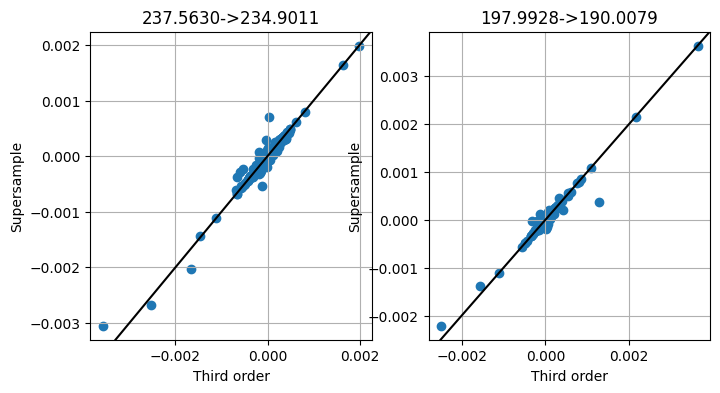

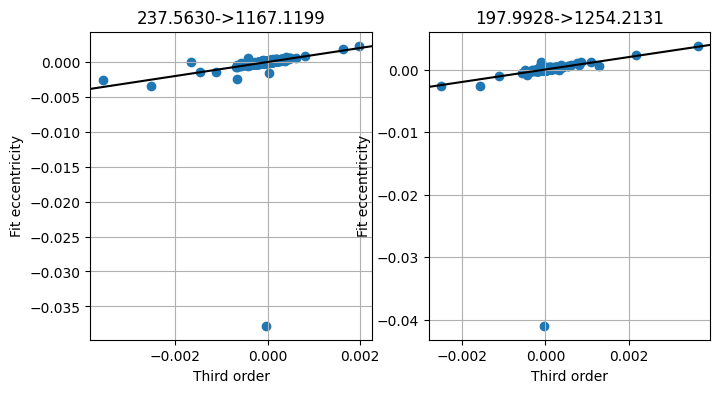

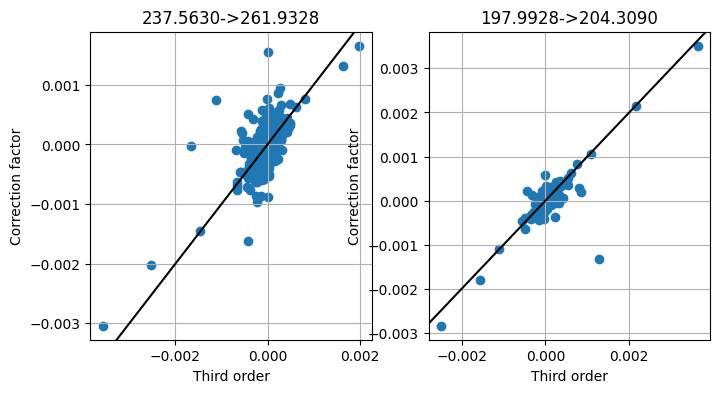

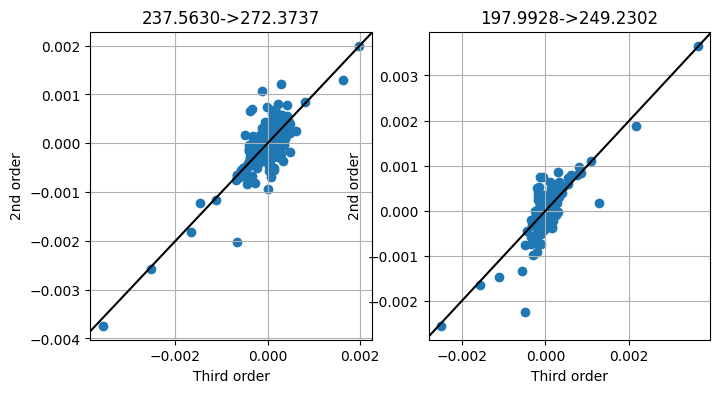

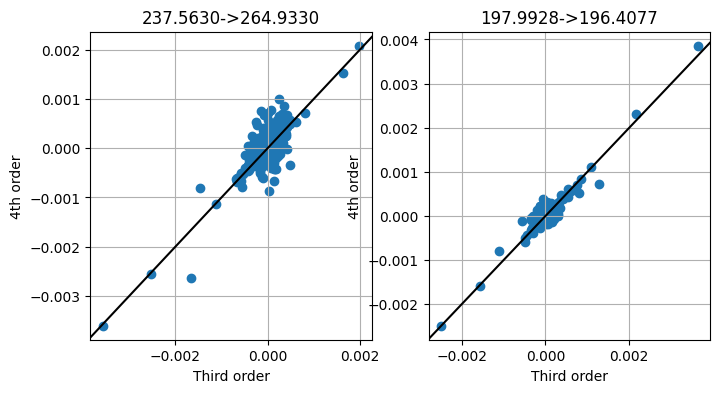

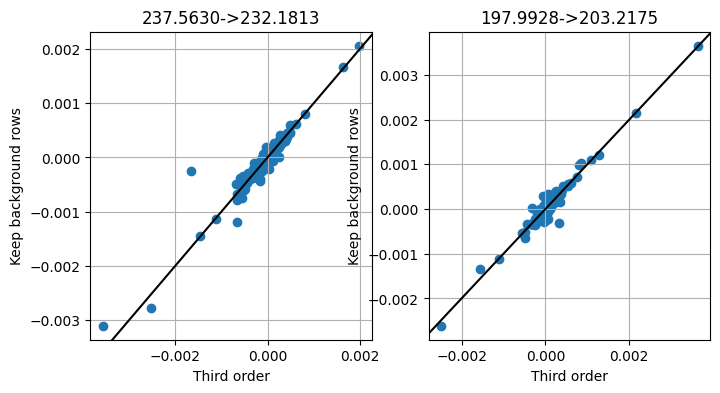

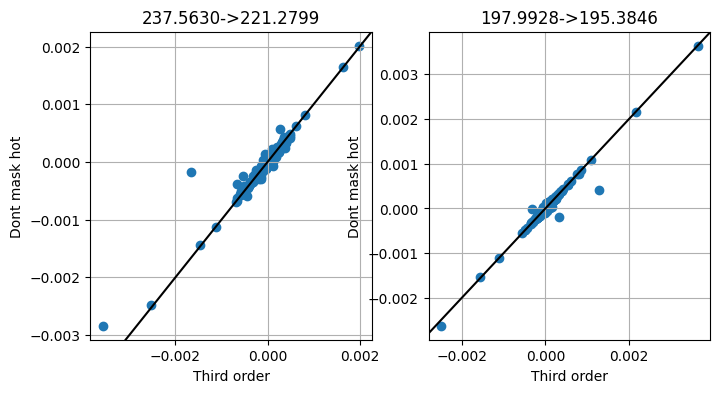

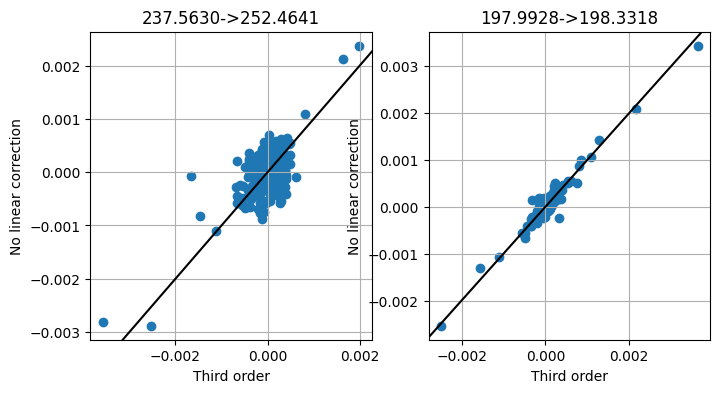

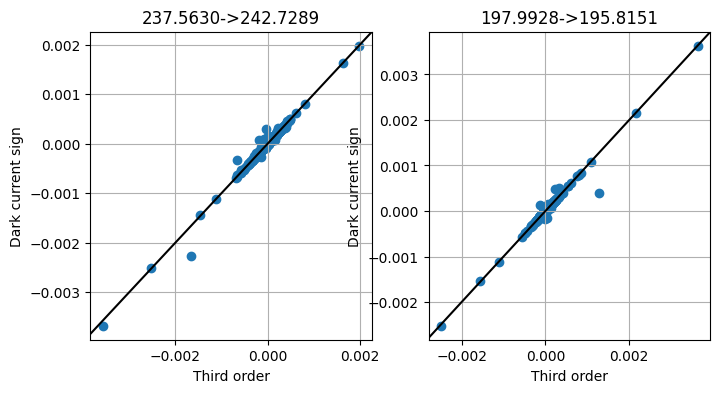

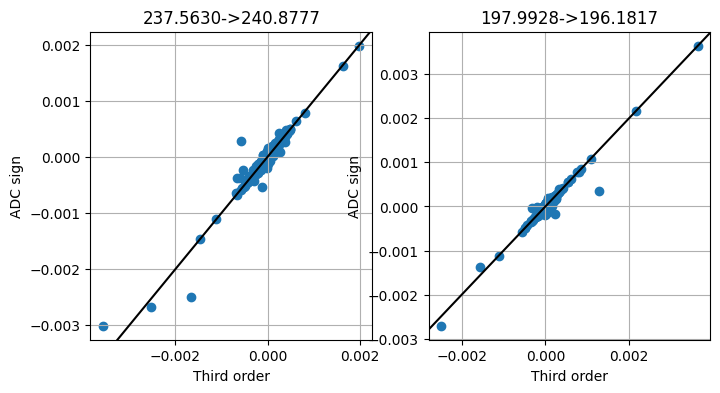

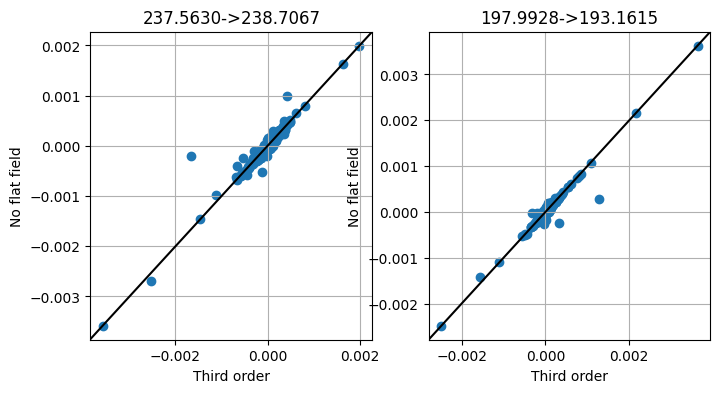

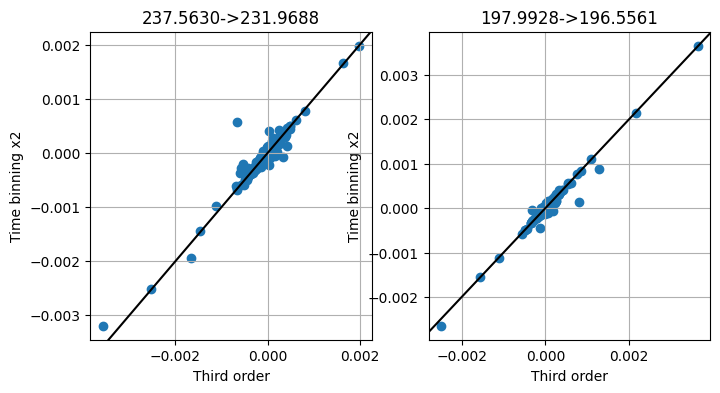

In [6]:
def process_solution(dat):
    solution = kgs.make_submission_dataframe(dat[0], include_sigma=False)
    submission = kgs.make_submission_dataframe(dat[1], False)
    fgs_err = robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), do_print=False)[1]
    airs_err = robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1), do_print=False)[1]
    return fgs_err,airs_err,dat[3]
dat_base = process_solution(kgs.dill_load(kgs.temp_dir + '/compare_simple'+str(0)+'.pickle'))
for jj in range(1,13):
    dat_this = process_solution(kgs.dill_load(kgs.temp_dir + '/compare_simple'+str(jj)+'.pickle'))
    _,ax = plt.subplots(1,2,figsize=(8,4))
    for ii in range(2):
        plt.sca(ax[ii])
        plt.grid(True)
        plt.scatter(dat_base[ii], dat_this[ii])
        plt.axline((0,0), slope=1, color='black')
        plt.title(f'{1e6*kgs.rms(dat_base[ii]):.4f}->{1e6*kgs.rms(dat_this[ii]):.4f}')
        plt.xlabel(dat_base[2])
        plt.ylabel(dat_this[2])